[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/junelsolis/AAU-Machine-Learning/HEAD)

# Initial setup and data import

In [1]:
!pip install tweet-preprocessor nltk keras-tuner textblob ipywidgets wordcloud pandarallel keras sklearn
!pip install tqdm>=4.9.0

In [2]:
# Make default library imports
import pandas as pd
import numpy as np
import preprocessor as p
import re
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

plt.style.use('fivethirtyeight')

%matplotlib inline

In [3]:
# Read the data from file
data = pd.read_csv('Sentiment140.tenPercent.sample.tweets.tsv', delimiter='\t')
data.head()


,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


Null values present in labels: False
Null values present in tweet text: False



<BarContainer object of 2 artists>

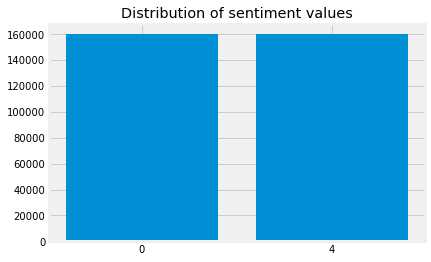

In [4]:
# Check for null values in the data
# Plot label histogram
print('Null values present in labels: ' + str(data['sentiment_label'].isnull().values.any()))
print('Null values present in tweet text: ' + str(data['tweet_text'].isnull().values.any()))
print()

plt.title('Distribution of sentiment values')
plt.bar(['0','4'], [len(data['sentiment_label'].where(data['sentiment_label'] == 0)), len(data['sentiment_label'].where(data['sentiment_label'] == 4))])


# Preprocess tweets

In [5]:
# Import NLTK dependencies
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))

# Spacy dependencies
# import spacy
# nlp = spacy.load('en', disable=['parser', 'ner'])

import random

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/junelsolis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/junelsolis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/junelsolis/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/junelsolis/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [6]:
from textblob import TextBlob, Word
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from os import path
# import multiprocessing as mp
from pandarallel import pandarallel

pandarallel.initialize(progress_bar = True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Text processing functions

In [7]:
def process_tweet(tweet):

  clean_tweet = tweet
  # clean_tweet = p.clean(tweet)
  
  # Remove punctuations and numbers
  clean_tweet = re.sub('[^a-zA-Z]', ' ', clean_tweet)

  # Convert to lower case
  clean_tweet = clean_tweet.lower()

  # Single character removal
  clean_tweet = re.sub(r"\s+[a-zA-Z]\s+", ' ', clean_tweet)

  # Removing multiple spaces
  clean_tweet = re.sub(r'\s+', ' ', clean_tweet)

  # Remove words longer than 41 chars
  clean_tweet_words = clean_tweet.split(' ')
  filter_max_word_length_tweet = []
  for w in clean_tweet_words:
    if (len(w) <= 40):
      filter_max_word_length_tweet.append(w)

  clean_tweet =  " ".join(filter_max_word_length_tweet)

  # Remove multiple spaces again
  clean_tweet = re.sub(r'\s+', ' ', clean_tweet)
  return clean_tweet


tag_dict = {"J": 'a', 
            "N": 'n', 
            "V": 'v', 
            "R": 'r'}

########################
########################
def lemmatize(tweet):
  blob = TextBlob(tweet)

  
  words_and_tags = [(Word(w), tag_dict.get(pos[0], 'n')) for w, pos in blob.tags]
  lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]

  return " ".join(lemmatized_list)


########################
########################
ps = PorterStemmer()

def stem(tweet):
  output = []
  for w in tweet.split():
      output.append("".join(ps.stem(w)))

  return " ".join(output)

########################
########################
def remove_stop_words(tweet):

  word_tokens = word_tokenize(tweet)  
  
  filtered_sentence = []  
    
  for w in word_tokens:  
      if w not in stop_words:  
          filtered_sentence.append(w)  

  return " ".join(filtered_sentence)

########################
########################
def correct_spelling(tweet):
  
    blob = TextBlob(tweet)
    return str(blob.correct())


########################
########################
def empty_single_word_tweets(tweet):
    if (len(tweet.split(' ')) > 1):
        return tweet
    else:
        return ''



## IMPORTANT ##
In this section, the tweet samples are preprocessed. As it takes a lot of time to do this, the pickled data has been saved to a file called __clean_data.pkl__

If this file exists in the project directoy, it is automatically loaded and used for the rest of the notebook. If refreshing the data is needed, then delete the __clean_data.pkl__ file and run the cell below. __Be advised:__ it will take at least half an hour on regular PC's.

In [8]:
# Clean the tweets. 
# Remove the following:
# - URLS
# - Hashtags
# - Mentions
# - Reserved words (RT, FAV)
# - Emojis
# - Smileys
# - Numbers

if path.exists('clean_data.pkl'):
    clean_data = pd.read_pickle('clean_data.pkl')
    
else:

    # initialize progress bars for pandas operations
    tqdm.pandas()

    # Copy the dataset and retain the original data
    clean_data = data.copy()
    clean_data = clean_data.sample(70000) # reduce number of samples

    # Convert labels to binary
    clean_data.loc[clean_data['sentiment_label'] == 4, 'sentiment_label'] = 1


    # Run initial clean with tweet-preprocessor
    print('Initial cleaning...\n')
    clean_data['tweet_text'] = clean_data['tweet_text'].progress_apply(lambda row: p.clean(row))

    # Correct spelling
    # print('Spelling check...\n')
    # clean_data['tweet_text'] = clean_data['tweet_text'].parallel_apply(lambda row: correct_spelling(row))

    # Lemmatize
    # clean_data['tweet_text'] = clean_data['tweet_text'].parallel_apply(lambda row: lemmatize(row))

    # Stemming
    # print('Stemming...\n')
    # clean_data['tweet_text'] = clean_data['tweet_text'].parallel_apply(lambda row: stem(row))

    # Run more cleaning
    # print('More cleaning...\n')
    # clean_data['tweet_text'] = clean_data['tweet_text'].parallel_apply(lambda row: process_tweet(row))

    # Remove stop words
    # print('Remove stop words...\n')
    # clean_data['tweet_text'] = clean_data['tweet_text'].parallel_apply(lambda row: remove_stop_words(row))

    # Remove tweets with only a single word
    # print('Remove single-word tweets...\n')
    # clean_data['tweet_text'] = clean_data['tweet_text'].parallel_apply(lambda row: empty_single_word_tweets(row))
    # clean_data.drop(clean_data[clean_data['tweet_text'] == ''].index, inplace=True)

    # Save cleaned data to pickle to save time later
    clean_data.to_pickle('clean_data.pkl')




  1%|          | 721/70000 [00:00<00:09, 7205.16it/s]Initial cleaning...

100%|██████████| 70000/70000 [00:09<00:00, 7600.46it/s]


In [9]:
# Print random sample of cleaned tweets
print(clean_data.count())
clean_data.sample(15)

sentiment_label    70000
tweet_text         70000
dtype: int64


,sentiment_label,tweet_text
82578,1,and tiffany gave me a visit when i wasn't supp...
31136,1,I'm there waiting and i already find out what'...
78111,1,your welcome
110649,1,"- miss you guys, hope you have a great weekend..."
132874,0,you can eat at my lola's house come here now.
475,1,Have a nice day too
37542,1,Photo shoot today and then hopefully a nice mo...
114298,1,- another pic of kim bum totally a hottie.
96834,1,Just thought of a great non-mariachi song to w...
78612,1,thanks


## Positive-sentiment words

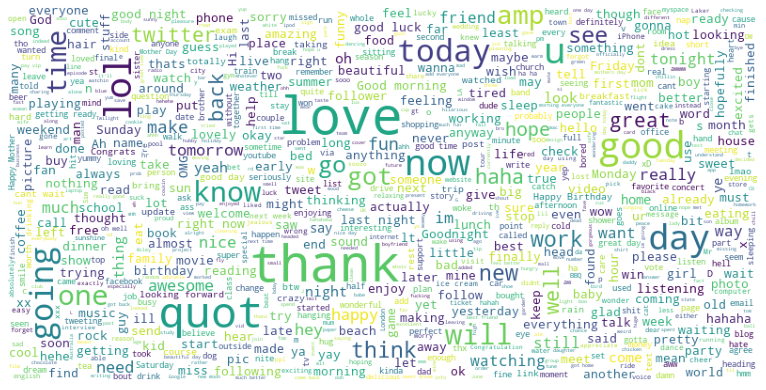

In [10]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color="white",max_words=800,max_font_size=55, relative_scaling=1, width=800, height=400).generate(' '.join(clean_data['tweet_text'].loc[clean_data['sentiment_label'] == 1]))

plt.figure(figsize=(12,7))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [11]:

# positive_filter_list = [
#     'quot',
#     'amp',
#     'work',
#     'go',
# ]

# clean_data = clean_data[clean_data['tweet_text'].str.contains('|'.join(positive_filter_list))]

# clean_data.loc[clean_data['sentiment_label'] == 1].count()

## Negative-sentiment words

(-0.5, 799.5, 399.5, -0.5)

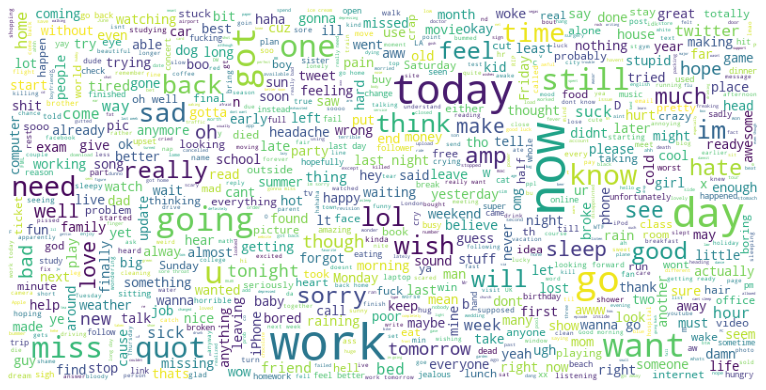

In [12]:
wordcloud = WordCloud(background_color="white",max_words=800,max_font_size=55, relative_scaling=1, width=800, height=400).generate(' '.join(clean_data['tweet_text'].loc[clean_data['sentiment_label'] == 0]))

plt.figure(figsize=(12,7))
plt.imshow(wordcloud)
plt.axis("off")

In [13]:
# negative_filter_list = [
#     'quot',
#     'lol',
#     'go',
#     'amp',
#     'ha',
# ]

# clean_data = clean_data[clean_data['tweet_text'].str.contains('|'.join(negative_filter_list))]
# clean_data.loc[clean_data['sentiment_label'] == 0].count()

# Support Vector Machine

## Prepare the dataset

In [15]:
# # Split the dataset into training and test
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(clean_data['tweet_text'], clean_data['sentiment_label'], test_size=0.2)

## Vectorize using TF-IDF

In [16]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tf_idf_vect = TfidfVectorizer(max_features=2000)
# tf_idf_vect.fit(clean_data['tweet_text'])

# X_train_tf_idf = tf_idf_vect.transform(X_train)
# X_test_tf_idf = tf_idf_vect.transform(X_test)


## Fit data to SVM

In [17]:
# from sklearn import model_selection, naive_bayes, svm


# # Classifier - Algorithm - SVM
# # fit the training dataset on the classifier
# SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', verbose=True)
# SVM.fit(X_train_tf_idf, y_train)

## Measure accuracy

In [18]:
# from sklearn.metrics import accuracy_score
# # predict the labels on validation dataset
# predictions_SVM = SVM.predict(X_test_tf_idf)
# # Use accuracy_score function to get the accuracy
# print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

# LSTM/RNN

In [19]:
# Tokenize the text corpus
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=2500, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n', split=" ")
tokenizer.fit_on_texts(clean_data['tweet_text'].values)

X = tokenizer.texts_to_sequences(clean_data['tweet_text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length

ModuleNotFoundError: No module named 'keras'

In [359]:
# Split the dataset into training and test
from sklearn.model_selection import train_test_split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, clean_data['sentiment_label'], test_size=0.2)

### Configure hyperparameter tuning

In [360]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

def build_model(hp):

    model = Sequential()

    hp_units_embed = hp.Int('units_embed', min_value = 8, max_value = 512, step = 32)
    model.add(Embedding(2500, hp_units_embed, input_length=X.shape[1]))

    # hp_spatial_dropout = hp.Float('spatial_dropout', min_value = 0.1, max_value = 0.6)
    # model.add(SpatialDropout1D(hp_spatial_dropout))

    hp_units_1 = hp.Int('units_1', min_value = 32, max_value = 512, step = 32)
    model.add(LSTM(hp_units_1, return_sequences = True, dropout = 0.3, recurrent_dropout = 0.2))
    
    hp_units_2 = hp.Int('units_2', min_value = 32, max_value = 512, step = 32)
    model.add(LSTM(hp_units_2, dropout=0.3, recurrent_dropout=0.2))
    
    model.add(Dense(2, activation='softmax'))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

    optimizer = hp.Choice('optimizer', ['adam', 'sgd']) 

    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    return model

In [361]:
import kerastuner as kt
import tensorflow as tf
import IPython

lstm_tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 5,
                     factor = 3,
                     directory = './',
                     project_name = 'lstm_tuning')


class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

lstm_tuner.search(X_train_lstm, y_train_lstm, epochs = 1, validation_split=0.3, callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = lstm_tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units_embed       |288               |?                 
units_1           |256               |?                 
units_2           |448               |?                 
learning_rate     |0.001             |?                 
optimizer         |adam              |?                 
tuner/epochs      |2                 |?                 
tuner/initial_e...|0                 |?                 
tuner/bracket     |1                 |?                 
tuner/round       |0                 |?                 

Epoch 1/2
 214/1217 [====>.........................] - ETA: 3:31 - loss: 0.6593 - accuracy: 0.5717

KeyboardInterrupt: 

In [ ]:
# Compile and train model
lstm_model = tuner.hypermodel.build(best_hps)
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs = 6, validation_split=0.3)
model.save('lstm')